# Loading Modules

In [181]:
#import sys
#sys.path.append('../../../Julia Gachot 2019/POLO/dev')

In [182]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from POLO.PYramid2 import cropped_pyramid, local_filter, get_K, log_gabor_transform
from POLO.PYramid2 import inverse_pyramid, get_K_inv, inverse_gabor
from utils import view_data
from typing import List, Tuple

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [183]:
args = init(filename='../data/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

# Log Gabor parameters

In [184]:
width = 64

n_levels = 2 

base_levels = 2

n_color = 1

r_min = width / 4 

r_max = width / 2 

n_sublevel = n_eccentricity = 4

n_azimuth = 16 *2

n_theta = 8

n_phase = 1

In [185]:
gauss = False
do_mask = False
color = False

In [186]:
pe = {'N_X': width, 'N_Y': width, 'do_mask': do_mask, 'base_levels':
          base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

lg = LogGabor(pe)

print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 64 64


i_sublevel, sf_0, radius 0 0.18033688011112042 16.0
i_sublevel, sf_0, radius 1 0.15164463602348005 19.027313840043536
i_sublevel, sf_0, radius 2 0.12751743082459868 22.62741699796952
i_sublevel, sf_0, radius 3 0.10722895046276856 26.908685288118864
K shape= torch.Size([64, 64, 4, 32, 8, 1])
K min max= tensor(-0.2759) tensor(1.)


Text(0.5, 1.0, 'K coefficients')

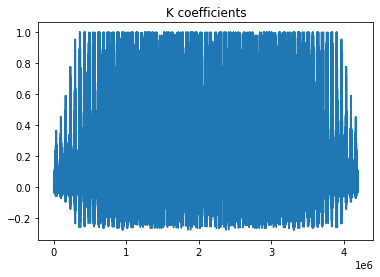

In [187]:
K = get_K(width=width,
          n_sublevel = n_sublevel, 
          n_azimuth = n_azimuth, 
          n_theta = n_theta,
          n_phase = n_phase, 
          r_min = r_min, 
          r_max = r_max, 
          log_density_ratio = 2, 
          verbose=True,
          lg=lg)

plt.plot(K.flatten())
plt.title('K coefficients')

### Honeycomb space coverage tests


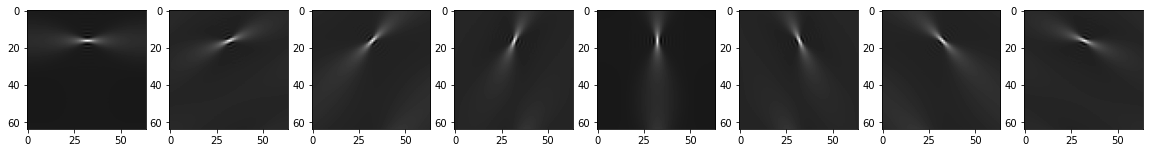

In [188]:
plt.figure(figsize=(20,3))
for i_theta in range(n_theta):
    coefs = torch.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
    coefs[0, n_azimuth//2, i_theta, 0] = 1
    img_dis = torch.tensordot(K, coefs, dims=4)
    plt.subplot(1,n_theta,i_theta+1)
    plt.imshow(img_dis.numpy()[:, :, ...], cmap='gray')

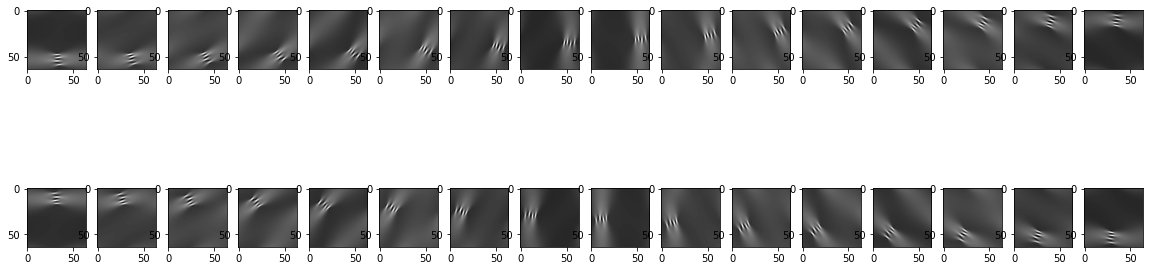

In [189]:
plt.figure(figsize=(20,6))
for i_az in range(n_azimuth):
    coefs = torch.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
    coefs[:, i_az, 0, 0] = 1
    img_dis = torch.tensordot(K, coefs, dims=4)
    plt.subplot(2,n_azimuth//2,i_az+1)
    plt.imshow(img_dis.numpy()[:, :, ...], cmap='gray')

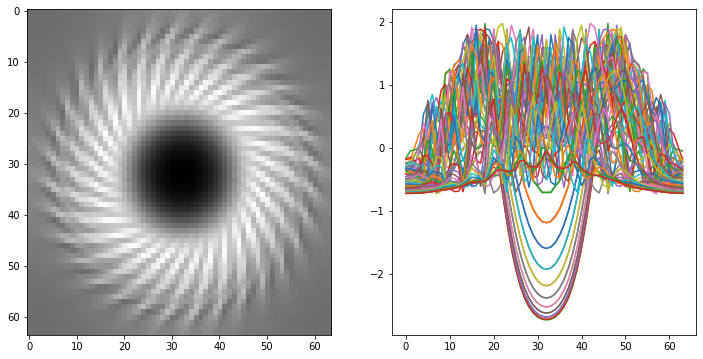

In [190]:
plt.figure(figsize=(12,6))
coefs = torch.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
coefs[:, :, 2:3, 0] = torch.ones((n_sublevel, n_azimuth, 1))
img_dis = torch.tensordot(K, coefs, dims=4)
plt.subplot(1,2,1)
plt.imshow(img_dis.numpy(), cmap='gray', aspect='auto')
plt.subplot(1,2,2)
_=plt.plot(img_dis.numpy())

## inverse Log Gabor

In [191]:
K.shape

torch.Size([64, 64, 4, 32, 8, 1])

Filter tensor shape= torch.Size([64, 64, 4, 32, 8, 1])
Reshaped filter tensor= torch.Size([4096, 1024])
Tensor shape= torch.Size([1024, 4096])


Text(0.5, 1.0, 'K_inv coefficients')

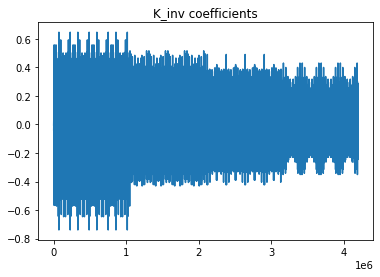

In [192]:
K_inv = get_K_inv(K, 
                  width=width, 
                  n_sublevel = n_sublevel, 
                  n_azimuth = n_azimuth, 
                  n_theta = n_theta, 
                  n_phase = n_phase)
plt.plot(K_inv.flatten())
plt.title('K_inv coefficients')

log_gabor_rosace shape:  torch.Size([1, 2, 4, 32, 8, 1])
img_crop_rosace shape: torch.Size([1, 2, 64, 64])


<Figure size 432x288 with 0 Axes>

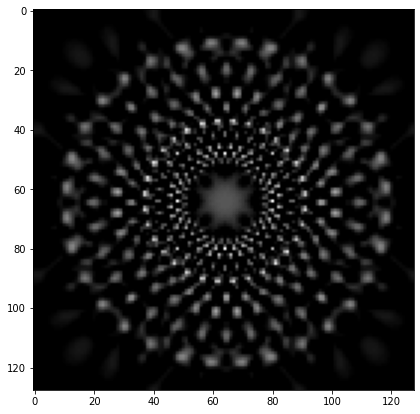

In [193]:
log_gabor_rosace = 100 * torch.ones(1, n_levels, n_eccentricity, n_azimuth, n_theta, n_phase)
plt.figure()
print('log_gabor_rosace shape: ', log_gabor_rosace.shape)

img_crop_rosace=inverse_gabor(log_gabor_rosace, K_inv)
print('img_crop_rosace shape:', img_crop_rosace.shape)
#img_crop_rosace[:,-1,...] = 128 
full_rosace = inverse_pyramid(img_crop_rosace, color=color, gauss=gauss, n_levels=n_levels, base_levels=base_levels)
full_rosace = full_rosace.detach().permute(0,2,3,1).numpy().clip(0,255).astype('uint8')
#ax = tensor_image_cmp(full_img_rec, full_img_rec_rec)
plt.figure(figsize=(7,7))
plt.imshow(full_rosace.squeeze(), cmap='gray')

In [194]:
img_crop_rosace.shape

torch.Size([1, 2, 64, 64])

### Adapted cropped pyramid (squeezed tensor)

In [195]:
class CroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode

    def __call__(self, img):
        img_crop, level_size = cropped_pyramid(img.unsqueeze(1), 
                                               width=self.width, 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels,
                                               color_mode=self.color_mode)
        return img, img_crop   

In [196]:
class DualCroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode

    def __call__(self, img):
        img_crop = {}
        for k in ['in', 'out']:
            img_crop_part, level_size = cropped_pyramid(img.unsqueeze(1), 
                                               width=self.width[k], 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels[k],
                                               color_mode=self.color_mode)
            img_crop[k] = img_crop_part[:self.n_levels[k]-1,...]
        return img, img_crop   

### LogGaborTransform

In [197]:
class LogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose

    def __call__(self, cropped_pyr):
        img = cropped_pyr[0]
        img_crop = cropped_pyr[1]
        log_gabor_coeffs = log_gabor_transform(img_crop.unsqueeze(1), K, color=self.color)
        
        return img, log_gabor_coeffs

In [198]:
class DualLogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose

    def __call__(self, cropped_pyr):
        img = cropped_pyr[0]
        img_crop = cropped_pyr[1]
        log_gabor_coeffs = {}
        for k in ['in', 'out']:
            log_gabor_coeffs[k] = log_gabor_transform(img_crop[k].unsqueeze(1), K[k], color=self.color)
        
        return img, log_gabor_coeffs

In [199]:
class LogGaborReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose

    def __call__(self, log_gabor_transform):
        img = log_gabor_transform[0]
        log_gabor_coeffs = log_gabor_transform[1]
        log_gabor_coeffs = log_gabor_coeffs.permute(1, 4, 5, 0, 2, 3).contiguous()
        log_gabor_coeffs = log_gabor_coeffs.view(self.n_color*self.n_theta*self.n_phase, 
                                                 self.n_levels * self.n_eccentricity, 
                                                 self.n_azimuth)
 
        return img, log_gabor_coeffs

In [200]:
class DualLogGaborReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose

    def __call__(self, log_gabor_transform):
        img = log_gabor_transform[0]
        log_gabor_coeffs = log_gabor_transform[1]
        for k in ['in', 'out']:
            log_gabor_coeffs[k] = log_gabor_coeffs[k].permute(1, 4, 5, 0, 2, 3).contiguous()
            log_gabor_coeffs[k] = log_gabor_coeffs[k].view(self.n_color[k]*self.n_theta[k]*self.n_phase[k], 
                                                     self.n_levels[k] * self.n_eccentricity[k], 
                                                     self.n_azimuth[k])
 
        return img, log_gabor_coeffs

### Inverse transformations (for display only)

In [201]:
class LogGaborInvReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):

        if self.verbose:
            print('log_gabor_coeffs.shape:', log_gabor_coeffs.shape)
        log_gabor_coeffs = log_gabor_coeffs.view(-1, 
                                                 self.n_color, 
                                                 self.n_theta, 
                                                 self.n_phase, 
                                                 self.n_levels, 
                                                 self.n_eccentricity, 
                                                 self.n_azimuth)
        log_gabor_coeffs = log_gabor_coeffs.permute(0, 4, 1, 5, 6, 2, 3).contiguous()
        return log_gabor_coeffs

In [202]:
class LogGaborInvTransform(object):
    def __init__(self, K_inv=K_inv, color=color, verbose=False):
        self.K_inv = K_inv
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):
        img_crop=inverse_gabor(log_gabor_coeffs[:, :, 0, ...].detach(), self.K_inv, self.verbose)
        if self.verbose:
            print('img_crop.shape:', img_crop.shape)

        return img_crop

In [203]:
class InvCroppedPyramid(object):
    def __init__(self, 
                 #width, 
                 base_levels, 
                 color=color, 
                 #do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb',
                 N_X = 128,
                 N_Y = 128):
        #self.width = width
        self.base_levels = base_levels
        self.color = color
        #self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode
        self.N_X = N_X
        self.N_Y = N_Y

    def __call__(self, img_crop):
        full_img_rec = inverse_pyramid(img_crop, 
                                       N_X = self.N_X,
                                       N_Y = self.N_Y,
                                       #width=self.width, 
                                       base_levels=self.base_levels,
                                       color=self.color, 
                                       #do_mask=self.do_mask, 
                                       verbose=self.verbose,
                                       #squeeze=True,
                                       gauss=gauss,
                                       n_levels=self.n_levels)
                                       #color_mode=self.color_mode)
        return full_img_rec

# Exploring the MNIST with where noise parameters and log polar encoding

- 128x128 pixel with shift, noise and circular mask

In [204]:
args.offset_max = 40 #like in the paper

In [205]:
args.offset_std = 30
args.contrast = 0.7

width = {'in': 32, 'out': 64}

n_levels = {'in': 3, 'out': 3} 

base_levels = 2

n_color = {'in': 1, 'out': 1}

r_min = {'in': width['in'] / 4, 'out': width['out'] / 4}

r_max = {'in': width['in'] / 2, 'out': width['out'] / 2}

n_sublevel = n_eccentricity = {'in': 2, 'out': 4}

n_azimuth = {'in': 16, 'out': 32}

n_theta = {'in': 8, 'out': 8}

n_phase = {'in': 1, 'out': 1}


In [206]:
lg={}
for k in ['in', 'out']:
    pe = {'N_X': width[k], 'N_Y': width[k], 'do_mask': do_mask, 'base_levels':
              base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
          'use_cache': True, 'figpath': 'results', 'edgefigpath':
              'results/edges', 'matpath': 'cache_dir', 'edgematpath':
              'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
              14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

    lg[k] = LogGabor(pe)

In [207]:
K = {}
for k in ['in', 'out']:
    K[k] = get_K(width=width[k],
          n_sublevel = n_sublevel[k], 
          n_azimuth = n_azimuth[k], 
          n_theta = n_theta[k],
          n_phase = n_phase[k], 
          r_min = r_min[k], 
          r_max = r_max[k], 
          log_density_ratio = 2, 
          verbose=True,
          lg=lg[k])

i_sublevel, sf_0, radius 0 0.36067376022224085 8.0
i_sublevel, sf_0, radius 1 0.25503486164919736 11.31370849898476
K shape= torch.Size([32, 32, 2, 16, 8, 1])
K min max= tensor(-0.3125) tensor(1.)
i_sublevel, sf_0, radius 0 0.18033688011112042 16.0
i_sublevel, sf_0, radius 1 0.15164463602348005 19.027313840043536
i_sublevel, sf_0, radius 2 0.12751743082459868 22.62741699796952
i_sublevel, sf_0, radius 3 0.10722895046276856 26.908685288118864
K shape= torch.Size([64, 64, 4, 32, 8, 1])
K min max= tensor(-0.2759) tensor(1.)


In [208]:
transform_big = transforms.Compose([
    RetinaFill(N_pic=args.N_pic),
    WhereShift(args),
    RetinaBackground(contrast=args.contrast,
                     noise=args.noise,
                     sf_0=args.sf_0,
                     B_sf=args.B_sf, flexible=True),
    RetinaMask(N_pic=args.N_pic),
    transforms.ToTensor(),
    DualCroppedPyramid(width, 
                  base_levels, 
                  n_levels=n_levels),
    DualLogGaborTransform(K=K, color=color),
    #DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),

])

In [209]:
train_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [210]:
data, label = next(iter(train_loader))
data_original = data[0]
data_polo = data[1]

In [211]:
data_original.shape, data_polo['in'].shape, data_polo['out'].shape

(torch.Size([100, 1, 128, 128]),
 torch.Size([100, 2, 1, 2, 16, 8, 1]),
 torch.Size([100, 2, 1, 4, 32, 8, 1]))

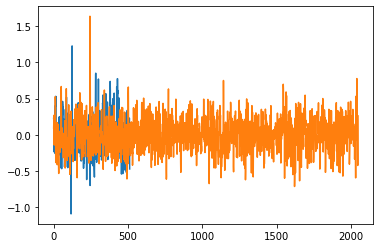

In [212]:
plt.plot(data_polo['in'][0,...].detach().numpy().flatten())
plt.plot(data_polo['out'][0,...].detach().numpy().flatten())


### Displaying Log Gabor Encoded visual field using pseudo-inverse transformation

In [213]:
K_inv={}
for k in ['in', 'out']:
    K_inv[k] = get_K_inv(K[k], 
                  width=width[k], 
                  n_sublevel = n_sublevel[k], 
                  n_azimuth = n_azimuth[k], 
                  n_theta = n_theta[k], 
                  n_phase = n_phase[k])

Filter tensor shape= torch.Size([32, 32, 2, 16, 8, 1])
Reshaped filter tensor= torch.Size([1024, 256])
Tensor shape= torch.Size([256, 1024])
Filter tensor shape= torch.Size([64, 64, 4, 32, 8, 1])
Reshaped filter tensor= torch.Size([4096, 1024])
Tensor shape= torch.Size([1024, 4096])


In [214]:
inverse_transform = {}
for k in ['in', 'out']:
    N_X = N_Y = width[k] * 2**(n_levels[k]-1)
    print(N_X)
    inverse_transform[k] = transforms.Compose([
        #LogGaborInvReshape(n_levels[k], n_color[k], n_eccentricity[k], n_azimuth[k], n_theta[k], n_phase[k], color=color, verbose=False),        
        LogGaborInvTransform(K_inv=K_inv[k], color=color, verbose=False),
        InvCroppedPyramid(base_levels, n_levels=n_levels[k], verbose=False, N_X=N_X, N_Y=N_Y),
    ])

128
256


In [215]:
full_img_rec.shape

torch.Size([100, 1, 256, 256])

- The Log-Polar compressed format

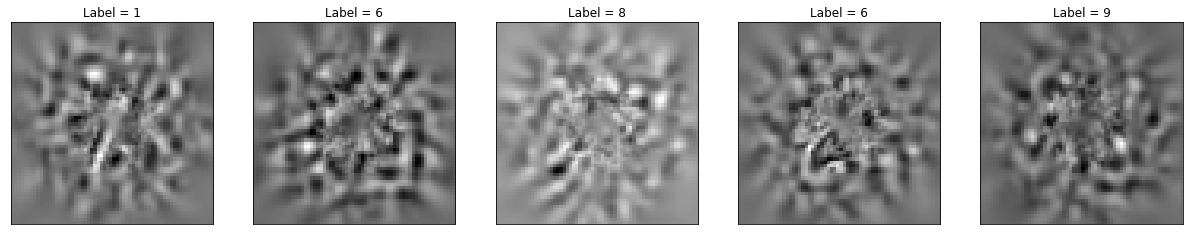

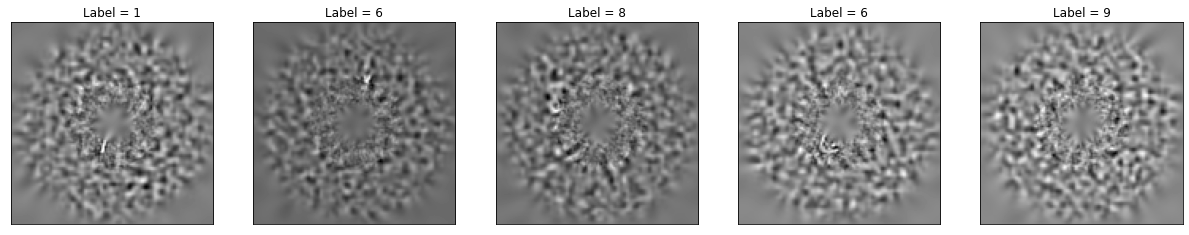

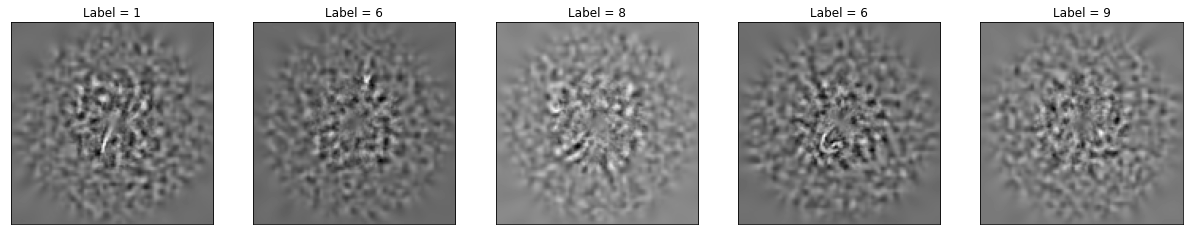

In [216]:
b = {'in':32,'out':64}
for k in ['in', 'out']:
    data = torch.cat((data_polo[k],torch.zeros_like(data_polo[k][:,:1,...])), dim=1)    
    full_img_rec = inverse_transform[k](data)
    img_aff = full_img_rec[:,:,b[k]:-b[k],b[k]:-b[k]]
    _ = view_data(img_aff, label, 5)
    if k == 'in':
        img_sum = full_img_rec
    else:
        img_sum += img_aff
_ = view_data(img_sum, label, 5)

- The original format

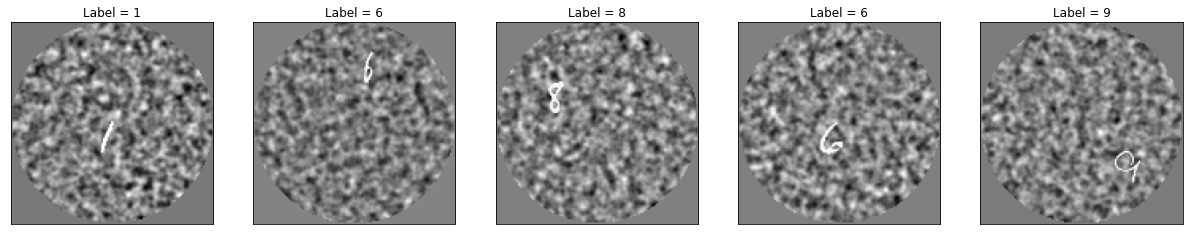

In [217]:
original = view_data(data_original, label, 5)

# Creating an Attention Transformer model with log-polar entry (POLO-STN)

In [226]:
class Polo_AttentionTransNet(nn.Module):
    
    def __init__(self):
        super(Polo_AttentionTransNet, self).__init__()

        ##  The what pathway
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)
        

        self.n_coefs = {}
        for k in ['in', 'out']:
            self.n_coefs[k] = (n_levels[k]-1) * n_color[k] * n_eccentricity[k] * n_azimuth[k] * n_theta[k] * n_phase[k]
        self.fc_loc = nn.Sequential(nn.Linear(self.n_coefs['in']+self.n_coefs['out'], 32),
                                    nn.ReLU(True),
                                    nn.Linear(32, 2))

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.zero_()

        self.downscale = nn.Parameter(torch.tensor([[0.2, 0], [0, 0.2]],
                                                   dtype=torch.float),
                                      requires_grad=False)

    def stn(self: object, x: torch.Tensor, x_polo: torch.Tensor) -> Tuple[torch.Tensor]:
    
        xs_part = {}
        for k in ['in', 'out']:
            xs_part[k] = x_polo[k].view(-1, self.n_coefs[k])
        xs = torch.cat((xs_part['in'], xs_part['out']), dim=1)
        theta = self.fc_loc(xs)

        theta = torch.cat((self.downscale.unsqueeze(0).repeat(
            theta.size(0), 1, 1), theta.unsqueeze(2)),
                          dim=2)
        
        #theta = theta.view(-1, 2, 3)
        
        grid_size = torch.Size([x.size()[0], x.size()[1], 28, 28])
        grid = F.affine_grid(theta, grid_size)
        x = F.grid_sample(x, grid)

        return x, theta

    def forward(self, x, x_polo):
        # transform the input
        x, _ = self.stn(x, x_polo)

        # Perform the usual forward pass
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [227]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = torch.load("../models/low_comp_polo_stn.pt")
model = Polo_AttentionTransNet().to(device)

In [228]:
def train(epoch, loader):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):

        data_original, data_polo = data[0], data[1]
        data_original, data_polo['in'], data_polo['out'], target = data_original.to(
            device, dtype=torch.double), data_polo['in'].to(
                device, dtype=torch.double), data_polo['out'].to(
                device, dtype=torch.double), target.to(device)

        optimizer.zero_grad()
        output = model(data_original, data_polo)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data_original),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data_original, data_polo = data[0], data[1]
            data_original = data_original.to(device, dtype=torch.double)            
            data_polo['in'] = data_polo['in'].to(device, dtype=torch.double) 
            data_polo['out'] = data_polo['out'].to(device, dtype=torch.double) 
            target = target.to(device)

            output = model(data_original, data_polo)

            # sum up batch loss
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset),
                     100. * correct / len(test_loader.dataset)))
        return correct / len(test_loader.dataset)

# Training parameters of the What/Where model

In [234]:
eccentricities = np.linspace(args.offset_max, 0, 9, endpoint=False)[::-1]
eccentricities

array([ 4.44444444,  8.88888889, 13.33333333, 17.77777778, 22.22222222,
       26.66666667, 31.11111111, 35.55555556, 40.        ])

In [235]:
contrasts = (0.7, 0.5, 0.3)

# Training on contrast 0.7

In [236]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1) #, verbose=True)

In [237]:
acc = []

In [233]:
for offset in eccentricities[:3]:

    args.offset_std = offset
    
    transform_big = transforms.Compose([
        RetinaFill(N_pic=args.N_pic),
        WhereShift(args),
        RetinaBackground(contrast=args.contrast,
                         noise=args.noise,
                         sf_0=args.sf_0,
                         B_sf=args.B_sf, flexible=True),
        RetinaMask(N_pic=args.N_pic),
        transforms.ToTensor(),
        DualCroppedPyramid(width, 
                       base_levels, 
                       n_levels=n_levels),
        DualLogGaborTransform(color=color),
        #LogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color)
    ])


    train_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=True,
        download=True,
        transform=transform_big,
    ),
                                               batch_size=args.minibatch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=False,
        download=True,
        transform=transform_big,
    ),
                                              batch_size=args.minibatch_size,
                                              shuffle=True)

    print("Training on eccentricity=%s" % (offset))
    args.epochs = 10

    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader)
        curr_acc = test(test_loader)
        acc.append(curr_acc)
        scheduler.step()

Training on eccentricity=4.444444444444443
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 2.305126
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 2.297535
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 2.293742
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 2.299805
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 2.297808
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 2.297328

Test set: Average loss: 0.0230, Accuracy: 1264/10000 (13%)

Train Epoch: 2/10 [0/60000 (0%)]	Loss: 2.291531
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 2.296961
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 2.296125
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 2.293763
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 2.290442
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 2.300572

Test set: Average loss: 0.0229, Accuracy: 2613/10000 (26%)

Train Epoch: 3/10 [0/60000 (0%)]	Loss: 2.288963
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 2.281944
Train Epoch: 3/10 [20000/60000 (33%)]	Loss: 2.276576
Train Epoch: 3/10 [30000/60000 (50%)]	Loss: 2.283980
Tr

Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 1.334807
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 1.445247

Test set: Average loss: 0.0148, Accuracy: 5109/10000 (51%)

Train Epoch: 3/10 [0/60000 (0%)]	Loss: 1.292495
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 1.438286
Train Epoch: 3/10 [20000/60000 (33%)]	Loss: 1.470889
Train Epoch: 3/10 [30000/60000 (50%)]	Loss: 1.191015
Train Epoch: 3/10 [40000/60000 (67%)]	Loss: 1.349690
Train Epoch: 3/10 [50000/60000 (83%)]	Loss: 1.584834

Test set: Average loss: 0.0147, Accuracy: 5151/10000 (52%)

Train Epoch: 4/10 [0/60000 (0%)]	Loss: 1.495222
Train Epoch: 4/10 [10000/60000 (17%)]	Loss: 1.351600
Train Epoch: 4/10 [20000/60000 (33%)]	Loss: 1.414724
Train Epoch: 4/10 [30000/60000 (50%)]	Loss: 1.467114
Train Epoch: 4/10 [40000/60000 (67%)]	Loss: 1.327542
Train Epoch: 4/10 [50000/60000 (83%)]	Loss: 1.257731

Test set: Average loss: 0.0145, Accuracy: 5214/10000 (52%)

Train Epoch: 5/10 [0/60000 (0%)]	Loss: 1.215510
Train Epoch: 5/10 [10000/60000 (17%)]

KeyboardInterrupt: 

In [ ]:
torch.save(model, "low_comp_polo_stn.pt")

# Training on lesser contrasts

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0005)
loss_func = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)

In [ ]:
for contrast in (0.5, 0.3):

    print("training on contrast %s" %(contrast))

    args.offset_std = 40 #train while the maximum range is 40
    args.contrast = contrast
    transform_big = transforms.Compose([
        RetinaFill(N_pic=args.N_pic),
        WhereShift(args),
        RetinaBackground(contrast=args.contrast,
                         noise=args.noise,
                         sf_0=args.sf_0,
                         B_sf=args.B_sf, flexible=True),
        RetinaMask(N_pic=args.N_pic),
        transforms.ToTensor(),
        DualCroppedPyramid(width, 
                       base_levels, 
                       n_levels=n_levels),
        DualLogGaborTransform(color=color),
        #LogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color)
    ])


    train_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=True,
        download=True,
        transform=transform_big,
    ),
                                               batch_size=args.minibatch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=False,
        download=True,
        transform=transform_big,
    ),
                                              batch_size=args.minibatch_size,
                                              shuffle=True)

    print("Training on eccentricity=%s" % (args.offset_std))
    args.epochs = 10

    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader)
        curr_acc = test(test_loader)
        #acc.append(curr_acc)
        scheduler.step()

# Saving the model

# Visualizing some transformations

In [ ]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    return inp

thetas = []
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        
        data, label = next(iter(test_loader))
        data_original = data[0][:16, ...].to(device)
        data_polo = {'in': data[1]['in'][:16, ...].to(device),
                     'out': data[1]['out'][:16, ...].to(device)}
        
        input_tensor = data_original.cpu()
        
        output_tensor, theta = model.stn(data_original, data_polo)
        thetas.append(theta)
        
        #output_tensor = F.pad(input=output_tensor, pad=(50, 50, 50, 50), mode='constant', value=0)

        transformed_input_tensor = output_tensor.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor, nrow=4))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor, nrow=4))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, dpi=300)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[0].set_xticks([0, 131])
        axarr[0].set_yticks([390])
        axarr[0].set_yticklabels([128])
        axarr[0].set_xticklabels([0, 128])

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        axarr[1].set_xticks([0, 30])
        axarr[1].set_yticks([90])
        axarr[1].set_yticklabels([28])
        axarr[1].set_xticklabels([0, 28])

        #f.savefig('../figures/polo_atn_attention.png')

In [ ]:
visualize_stn()

# Performance of the Polo-ATN

In [ ]:
def test(loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data_original, data_polo = data[0], data[1]
            data_original = data_original.to(device, dtype=torch.double)            
            data_polo['in'] = data_polo['in'].to(device, dtype=torch.double) 
            data_polo['out'] = data_polo['out'].to(device, dtype=torch.double) 
            target = target.to(device)

            output = model(data_original, data_polo)

            # sum up batch loss
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset),
                     100. * correct / len(test_loader.dataset)))
        return correct / len(test_loader.dataset)

In [ ]:
polo_atn_stats = {}

for contrast in contrasts:
    print("Testing on contrast = %s" % (contrast))

    accuracies = []

    for ecc in eccentricities:
        

        transform_big = transforms.Compose([
            RetinaFill(N_pic=args.N_pic),
            WhereShift(args, radius=ecc),  # given eccentricity
            RetinaBackground(
                contrast=contrast,  # given contrast
                noise=args.noise,
                sf_0=args.sf_0,
                B_sf=args.B_sf,
                flexible=False),  # a fixed contrast
            RetinaMask(N_pic=args.N_pic),
            transforms.ToTensor(),
            DualCroppedPyramid(width, base_levels, n_levels=n_levels),
            DualLogGaborTransform(color=color),
            #DualLogGaborReshape(n_levels,
            #                n_color,
            #                n_eccentricity,
            #                n_azimuth,
            #                n_theta,
            #                n_phase,
            #                color=color)
        ])
        train_loader = torch.utils.data.DataLoader(
            MNIST(
                '../data',
                train=True,
                download=True,
                transform=transform_big,
            ),
            batch_size=args.minibatch_size,
            shuffle=True)

        test_loader = torch.utils.data.DataLoader(
            MNIST(
                '../data',
                train=False,
                download=True,
                transform=transform_big,
            ),
            batch_size=args.minibatch_size,
            shuffle=True)
        print("Testing on eccentricity = %s" % (ecc))
        acc = test(test_loader)
        accuracies.append(acc)

    polo_atn_stats[contrast] = np.array(accuracies)

In [ ]:
polo_atn_stats